# <font color="purple">**Proyecto: Consumo de alcohol en estudiantes**</font>

### Angelica Nayeli Rivas Bedolla

## Librerías

In [1]:
#pandas
import pandas as pd

#bokeh
from bokeh.palettes import RdBu  # just make sure to import a palette that centers on white (-ish)
from bokeh.models import ColorBar, LinearColorMapper
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot

#model
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree
import graphviz

#others for visualization
import bisect
from math import ceil, pi
from numpy import arange
from itertools import chain
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
%matplotlib inline

## Funciones

In [5]:
def graficar_arbol(clf, atributos, etiquetas):
    dot_data = tree.export_graphviz(clf, out_file=None,filled = True , feature_names = atributos, class_names = etiquetas) 
    graph = graphviz.Source(dot_data) 
    return graph

In [6]:
def fit_DTC(Datos, params, semilla = 42):
    '''Analyses by grid search the best decision tree classifier.
    
    Parameters
    -----------
    datos: Pandas dataframe
        Dataset which will be classified.
    params: Dictionary
        Dictionary with the params for gird search.
    semilla: Integer
        Seed for random. For default 42.
    
    Output
    -----------
    Prints confusion matrix, accuracy and best params and returns the best estimator for the grid search.
    
    '''   
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(Datos[Datos.columns[:-1]], Datos[Datos.columns[-1]], test_size=0.3 , random_state= semilla)
    
    grid_search_cv = GridSearchCV( DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=3 )
    grid_search_cv.fit(Xtrain, Ytrain)
    
    predicho = grid_search_cv.predict(Xtest)
    
    print( "\n Matriz de confusion" )
    print( metrics.confusion_matrix(Ytest,predicho) )
    
    print( "\n Precisión" )
    print( metrics.accuracy_score(Ytest, predicho) )
    
    print("\n Mejores parámetros")
    print(grid_search_cv.best_params_)
    
    return grid_search_cv.best_estimator_

In [7]:
# Funciones obtenidas del curso de Machine Learning
def dataframe_histograms(dataframe):
    ''' Plots histograms of all atributes of a dataset
    
    Parameters
    -----------
    dataframe: Pandas dataframe
        Dataset whose attributes' histograms will be plotted.
    
    '''
    dataframe.hist(bins=50, figsize=(20,15))
    plt.gcf().canvas.set_window_title("Attribute Histograms")
    plt.show()


In [21]:
def correlations(dataframe, valor, attributes=-1):
    '''Analyses correlation between valor and the other attributes 
    of the dataset by numerical calculation.
    
    Parameters
    -----------
    dataframe: Pandas dataframe
        Dataset whose attributes' correlation will be calculated.
    valor: String
        Principal attribute correlated with.
    attributes: Integer
        For default is -1, will return correlation of all attributes.
        if is not -1 will return the most n correlated (included inverse correlation) attributes.
    
    '''    
    corr_matrix = dataframe.corr()
    corr_values = corr_matrix[valor].sort_values(ascending=False)
    
    if attributes != -1:
        correlaciones_abs =  pd.DataFrame( pd.DataFrame(corr_values.copy(deep=True).abs()).sort_values(ascending=False, by=["Alc"])[0:attributes]).index
        return correlaciones_abs
    
    return corr_values

def correlaciones(df, principal, attributes=-1): #(Philly, 2018)
    '''Analyses correlation between valor and the other attributes 
    of the dataset by a colormap.
    
    Parameters
    -----------
    dataframe: Pandas dataframe
        Dataset whose attributes' correlation will be plotted.
    principal: String
        Principal attribute correlated with.
    attributes: Integer
        For default is -1, will plot the correlation of all attributes.
        if is not -1 will plot the most n correlated (included inverse correlation) attributes. 
    
    '''    
    colors = list(reversed(RdBu[9]))  # we want an odd number to ensure 0 correlation is a distinct color    
    
    if attributes == -1:
        labels = df.columns
    else:
        labels = correlations(df,principal, attributes)
    
    p_corr = df.loc[:,labels].corr()
    nlabels = len(labels)

    def get_bounds(n):
        """Gets bounds for quads with n features"""
        bottom = list(chain.from_iterable([[ii]*nlabels for ii in range(nlabels)]))
        top = list(chain.from_iterable([[ii+1]*nlabels for ii in range(nlabels)]))
        left = list(chain.from_iterable([list(range(nlabels)) for ii in range(nlabels)]))
        right = list(chain.from_iterable([list(range(1,nlabels+1)) for ii in range(nlabels)]))
        return top, bottom, left, right

    def get_colors(corr_array, colors):
        """Aligns color values from palette with the correlation coefficient values"""
        ccorr = arange(-1, 1, 1/(len(colors)/2))
        color = []
        for value in corr_array:
            ind = bisect.bisect_left(ccorr, value)
            color.append(colors[ind-1])
        return color

    p = figure(plot_width=600, plot_height=600,
               x_range=(0,nlabels), y_range=(0,nlabels),
               title="Correlation Coefficient Heatmap (lighter is worse)",
               toolbar_location=None, tools='')

    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.major_label_orientation = pi/4
    p.yaxis.major_label_orientation = pi/4

    top, bottom, left, right = get_bounds(nlabels)  # creates sqaures for plot
    color_list = get_colors(p_corr.values.flatten(), colors)

    p.quad(top=top, bottom=bottom, left=left,
           right=right, line_color='white',
           color=color_list)

    # Set ticks with labels
    ticks = [tick+0.5 for tick in list(range(nlabels))]
    tick_dict = OrderedDict([[tick, labels[ii]] for ii, tick in enumerate(ticks)])
    # Create the correct number of ticks for each axis 
    p.xaxis.ticker = ticks
    p.yaxis.ticker = ticks
    # Override the labels 
    p.xaxis.major_label_overrides = tick_dict
    p.yaxis.major_label_overrides = tick_dict

    # Setup color bar
    mapper = LinearColorMapper(palette=colors, low=-1, high=1)
    color_bar = ColorBar(color_mapper=mapper, location=(0, 0))
    p.add_layout(color_bar, 'right')

    show(p)

def zoom_histogram(df, categoria, color):
    # School
    ## Create the blank plot
    p = figure(plot_height = 250, plot_width = 250, 
           title = f'Histogram of {categoria}',
           x_axis_label = 'Categoria', 
           y_axis_label = 'Frecuencia')
    
    aux = pd.DataFrame(columns=["frecuencia"])
    for a,b in enumerate(estudiantes[categoria].value_counts()):
        aux.loc[a]=[b]
    
    p.quad(bottom=0, top=aux['frecuencia'], 
       left=aux.index-.3, right=aux.index+.3, 
       fill_color=color, line_color=color)
    
    return p

## Preprocesamiento de los datos

### Contexto:

Los datos se obtuvieron en una encuesta de estudiantes de matemática y portugués en la escuela secundaria. Contiene mucha información social, de género y de estudio interesante sobre los estudiantes.

### Contenido:

   1. school - escuela perteneciente (binario: 0 - Gabriel Pereira o 1 - Mousinho da Silveira)
   2. sex - sexo del estudiante (binario: 0 - femenino or 1 - masculino)
   3. age - edad del estudiante (numerico: desde 15 hasta 22)
   4. address - tipo de vivienda del estudiante (binario: 0 - rural o 1 - urbano)
   5. famsize - tamaño de la familia (binario: 0 - mayor que 3 o 1 - menor o igual a 3)
   6. Pstatus - estado de convivencia de los padres (binario: 0 - apartados o 1 - viven juntos)
   7. Medu - educacion de la madre (numerico: 0 - ninguno, 1 - educacion primaria (4to grado), 2 – 5to a 9no grado, 3 – educacion secundaria o 4 – educacion superior)
   8. Fedu - educacion del padre (numerico: 0 - ninguno, 1 - educacion primaria (4to grado), 2 – 5to a 9no grado, 3 – educacion secundaria o 4 – educacion superior)
   9. Mjob - trabajo de la madre (numerico: 0 - en casa, 1 - relacionados a salud, 3 - sevicios civiles (e.g. administrativo o policia), 4 - profesor, 2 - otro)
   10. Fjob - trabajo del padre (numerico: 0 - en casa, 1 - relacionados a salud, 3 - sevicios civiles (e.g. administrativo o policia), 4 - profesor, 2 - otro)
   11. reason - razon por la cual escogió la escuela (numerico: 0 - preferencia del curso, 1 - cercano a casa, 3 - reputacion de la escuela o 2 - otro)
   12. guardian - tutor del estudiante (numerico: 0 - padre, 1 - madre o 2 - otro)
   13. traveltime - tiempo de transporte de casa a escuela (numerico: 1 - <15 min., 2 - 15 hasta 30 min., 3 - 30 min. hasta 1 hora, or 4 - >1 hora)
   14. studytime - tiempo semanal de estudio (numerico: 1 - <2 horas, 2 - 2 hasta 5 horas, 3 - 5 hasta 10 horas, o 4 - >10 horas)
   15. failures - numero de clases fallidas (numerico: n si 1<=n<3, entonces 4)
   16. schoolsup - soporte extra educacional (binario: 0 - no o 1 - si )
   17. famsup - soporte educacional familiar (binario: 0 - no o 1 - si )
   18. paid_port - asesorias extras pagadas. (binario: yes - si o no)
   19. paid_math - asesorias extras pagadas. (binario: yes - si o no)
   20. activities - actividades extra-curriculares (binario: 0 - no o 1 - si )
   21. nursery - asistió a la guarderia (binario: 0 - no o 1 - si )
   22. higher - quiere estudiar nivel superior educacional (binario: 0 - no o 1 - si )
   23. internet - acceso a Internet en casa (binario: 0 - no o 1 - si )
   24. romantic - en una relación romantica (binario: 0 - no o 1 - si )
   25. famrel - calidad de la relación familiar (numerico: desde 1 - muy mala hasta 5 - excelente)
   26. freetime - tiempo libre después de la escuela (numerico: desde 1 - muy baja hasta 5 - muy alta)
   27. goout - salir con amigos (numerico: desde 1 - muy baja hasta 5 - muy alta)
   28. health - estado de salud actual (numerico: desde 1 - muy mala hasta 5 - muy buena)
   29. absences - numero de faltas en la escuela (numerico: desde 0 hasta 93)
   30. c_port - cursa portugués (binario: 0 - no o 1 - si )
   31. c_math - cursa matemáticas (binario: 0 - no o 1 - si )
   32. G1_port - calificacion de primer periodo en portugués (numerico: desde 0 hasta 20)
   33. G2_port - calificacion de segundo periodo en portugués (numerico: desde 0 hasta 20)
   34. G3_port - calificacion de tercer periodo en portugués (numerico: desde 0 hasta 20)
   35. G1_math - calificacion de primer periodo en metamáticas (numerico: desde 0 hasta 20)
   36. G2_math - calificacion de segundo periodo en metamáticas (numerico: desde 0 hasta 20)
   37. G3_math - calificacion de tercer periodo en metamáticas (numerico: desde 0 hasta 20)
   38. Alc - consumo de alcohol durante la semana (numerico: desde 1 - muy baja hasta 5 - muy alta)

### Cargando datos

In [5]:
estudiantes = pd.read_csv('../Data/estudiantes.csv')

### Explorando los datos

In [9]:
estudiantes.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid_port', 'paid_math',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'c_port', 'c_math',
       'G1_port', 'G2_port', 'G3_port', 'G1_math', 'G2_math', 'G3_math',
       'Alc'],
      dtype='object')

In [10]:
estudiantes.shape

(959, 38)

In [11]:
estudiantes.tail(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,absences,c_port,c_math,G1_port,G2_port,G3_port,G1_math,G2_math,G3_math,Alc
949,1,0,18,1,1,1,1,1,0,3,...,0,1,1,19,17,18,18,16,16,1
950,1,0,17,0,0,1,1,2,2,3,...,0,1,1,13,13,13,12,11,12,1
951,1,1,18,1,1,1,4,4,4,3,...,0,1,1,15,16,16,13,13,13,2
952,1,0,17,0,0,1,1,1,2,3,...,0,1,1,8,8,9,7,6,0,1
953,1,0,18,1,0,1,2,3,0,3,...,0,1,1,10,10,10,11,10,10,1
954,1,1,18,0,1,1,1,2,0,3,...,3,1,1,9,10,10,14,12,12,2
955,1,0,17,1,0,1,2,2,2,0,...,8,1,1,10,11,12,13,11,11,1
956,1,0,18,0,1,1,4,4,2,2,...,0,1,1,15,17,17,19,18,19,1
957,1,1,18,1,0,1,4,4,4,4,...,4,1,1,17,18,19,15,14,14,2
958,1,1,19,0,0,1,1,1,2,3,...,0,1,1,5,8,0,6,5,0,2


## Visualizando los datos

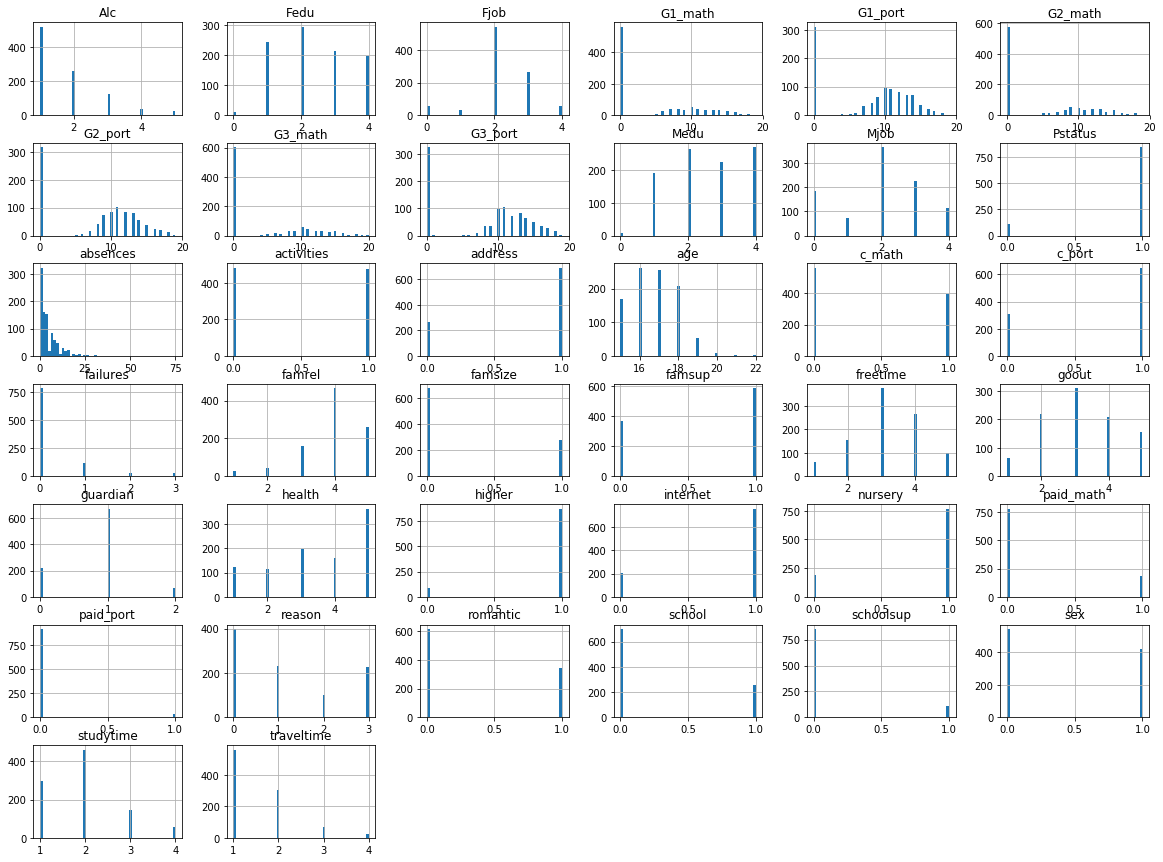

In [12]:
dataframe_histograms(estudiantes)

In [6]:
correlations(estudiantes, "Alc")

Alc           1.000000
goout         0.369212
sex           0.341920
freetime      0.159555
absences      0.127636
failures      0.122910
age           0.109593
traveltime    0.101568
famsize       0.090033
health        0.086235
Fjob          0.057177
Mjob          0.049545
internet      0.045477
Pstatus       0.036457
paid_port     0.033219
school        0.028652
activities    0.020814
Fedu          0.019802
paid_math     0.017216
romantic      0.017143
guardian     -0.008573
Medu         -0.010330
c_math       -0.016357
reason       -0.020426
c_port       -0.031948
G3_math      -0.032070
G2_math      -0.036525
schoolsup    -0.043627
G1_math      -0.044512
address      -0.047450
famsup       -0.056650
nursery      -0.087315
famrel       -0.087326
G2_port      -0.095140
G1_port      -0.096530
G3_port      -0.106156
higher       -0.106299
studytime    -0.189822
Name: Alc, dtype: float64

In [41]:
correlaciones(estudiantes, "Alc")

In [40]:
a = zoom_histogram(estudiantes, "sex", "red")
b = zoom_histogram(estudiantes, "school", "green")
c = zoom_histogram(estudiantes, "goout", "blue")
d = zoom_histogram(estudiantes, "Alc", "pink")
show(gridplot([[a, b], [c, d]]))

# Árboles de decisión!

In [38]:
params1 = {'splitter': ["best","random"],
          'criterion': ["gini", "entropy"],
          "max_depth": [None, 3, 4, 5, 6, 7, 8, 9],
          "min_samples_split": [20, 30, 40, 50, 60, 70, 80],
          "min_samples_leaf": range(1, 50, 5),
          "max_leaf_nodes": range(2,10),
          "presort":[True, False]
         }
clasificador1 = fit_DTC(estudiantes, params1)

Fitting 3 folds for each of 35840 candidates, totalling 107520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 3320 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 7820 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 14120 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 22220 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 32120 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 43820 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 57320 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 72620 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 89720 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 107520 out of 107520 | elapsed:  5.2min finished



 Matriz de confusion
[[146   0   9   0   0]
 [ 73   0  13   0   0]
 [ 18   0  13   0   0]
 [  4   0   9   0   0]
 [  0   0   3   0   0]]

 Precisión
0.5520833333333334

 Mejores parámetros
{'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 4, 'min_samples_leaf': 1, 'min_samples_split': 20, 'presort': True, 'splitter': 'random'}


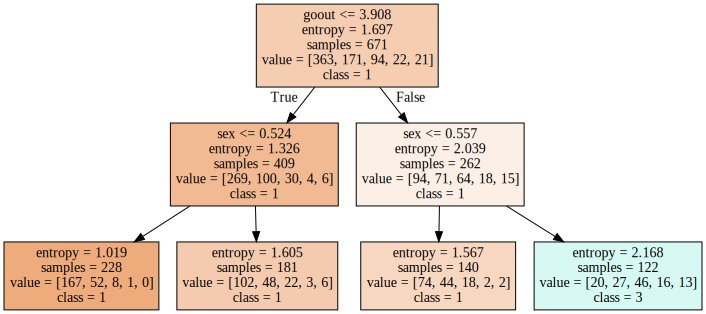

In [40]:
graficar_arbol(clasificador1, estudiantes.columns[:-1], [str(i) for i in range(1,6)])

In [36]:
params3 = {'criterion': ["gini", "entropy"],
          "max_depth": [3, 4, 5, 6, 7, None],
          "max_leaf_nodes": range(5,15),
          "min_samples_leaf": range(2, 10),
          "min_samples_split": range(2,25),
          "presort":[True],
          'splitter': ["best","random"]
         }
clasificador3 = fit_DTC(estudiantes, params3)

Fitting 3 folds for each of 44160 candidates, totalling 132480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 155 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2555 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 6555 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 12155 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 19355 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 28155 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 38555 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 50555 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 64155 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 79355 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 96155 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 114555 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 132480 out of 132480 | elapsed:  6.9min finished



 Matriz de confusion
[[140   6   9   0   0]
 [ 67   6  13   0   0]
 [ 15   3  13   0   0]
 [  4   0   9   0   0]
 [  0   0   3   0   0]]

 Precisión
0.5520833333333334

 Mejores parámetros
{'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'presort': True, 'splitter': 'best'}


/home/angelica/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


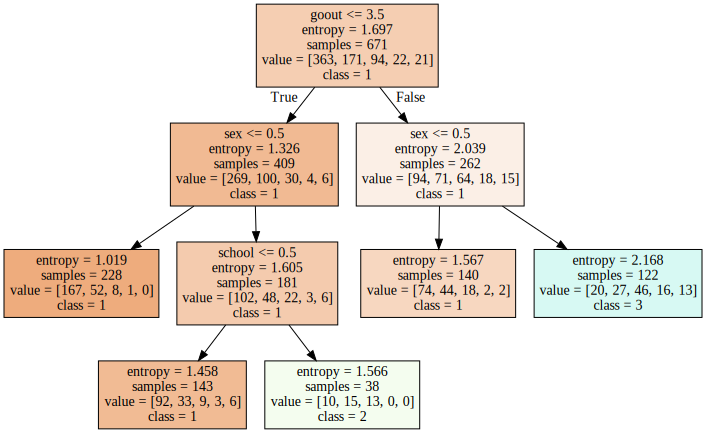

In [37]:
graficar_arbol(clasificador3, estudiantes.columns[:-1], [str(i) for i in range(1,6)])

# Referencias

1. UCI Machine Learning. (2016). [Student Alcohol Consumptions](https://www.kaggle.com/uciml/student-alcohol-consumption).

2. Scikit-learn Documentation. [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

3. Scikit-learn Documentation. [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

4. Philly. (2018). ["python bokeh, how to make a correlation plot?"](https://stackoverflow.com/questions/39191653/python-bokeh-how-to-make-a-correlation-plot).